# Policy Iteration
In this notebook we look at a Policy Iteration and how it can be implemented as part of an Finite differences scheme in order to solve non-linear optimal control problems. A suitable toy model for policy iteration is LQR. We use the a one dimensional control and one dimensional variable. Firstly, we will solve it analytically and plot it. Then we will develop an FDM scheme that tries to approximate the solution. 

Consider the control problem
$$
\text{minimize } J(u) = \int_0^T (x^2 + u^2)\, dt
$$
subject to the dynamics
$$
\dot{x} = a x + b u, \quad x(0) = x_0 = 1. 
$$

**HJB Equation:** The value function $V(t,x)$ satisfies
$$
-\frac{\partial V}{\partial t} = \sup_u \Big\{ x^2 + u^2 + \frac{\partial V}{\partial x} (a x + b u) \Big\}.
$$ With $V(x,T) = 0$

**Optimal Control:** Maximizing with respect to $u$,
$$
\frac{\partial}{\partial u} \big(u^2 + b \frac{\partial V}{\partial x} u \big) = 2 u + b \frac{\partial V}{\partial x} = 0
\quad \Rightarrow \quad
u^*(t) = -\frac{b}{2} \frac{\partial V}{\partial x}.
$$

Substituting $u^*$ into the HJB gives
$$
-\frac{\partial V}{\partial t} = x^2 + \left(-\frac{b}{2} V_x\right)^2 + V_x \left(a x - \frac{b^2}{2} V_x\right)
= x^2 + a x V_x - \frac{b^2}{4} (V_x)^2.
$$

**Quadratic Ansatz:** Assume $V(t,x) = P(t) x^2$, then
$$
V_x = 2 P(t) x, \quad V_t = \dot{P}(t) x^2.
$$
Substituting gives the Riccati ODE
$$
\dot{P} = b^2 P^2 - 2 a P - 1, \quad P(T) = 0.
$$

**Solution:** Let $\lambda = \sqrt{a^2 + b^2}$. Then the solution is
$$
P(t) = \frac{1}{b} \Big( \lambda \, \tanh(\lambda (T - t) + \tanh^{-1} \frac{a}{\lambda}) - a \Big).
$$

**Optimal Control Law:**
$$
u^*(t) = -b P(t) x = - \big( \lambda \, \tanh(\lambda (T - t) + \tanh^{-1} \frac{a}{\lambda}) - a \big) x.
$$

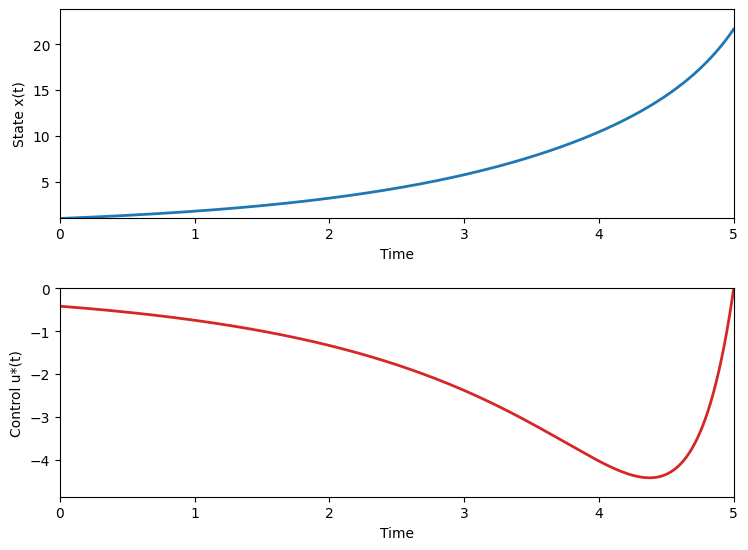

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters
a = 1.0
b = 1.0
T = 5.0
dt = 0.01
x0 = 1  # initial state

# Derived parameter
lambda_ = np.sqrt(a**2 + b**2)
phi = np.arctanh(a / lambda_)

# Time grid
t = np.arange(0, T + dt, dt)

# Riccati solution P(t)
P = (1/b) * (lambda_ * np.tanh(lambda_ * (T - t) + phi) - a)

# Initialize arrays
x = np.zeros_like(t)
x[0] = x0
u = np.zeros_like(t)

# Integrate system forward using Euler method with optimal control u = -b P x
for i in range(1, len(t)):
    u[i-1] = -b * P[i-1] * x[i-1]
    x[i] = x[i-1] + dt * (a * x[i-1] + b * u[i-1])

u[-1] = -b * P[-1] * x[-1]

# --- Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plt.tight_layout(pad=3.0)

# Configure axes
ax1.set_xlim(0, T)
ax1.set_ylim(min(x) * 1.1, max(x) * 1.1)
ax1.set_xlabel("Time")
ax1.set_ylabel("State x(t)")

ax2.set_xlim(0, T)
ax2.set_ylim(min(u) * 1.1, max(u) * 1.1)
ax2.set_xlabel("Time")
ax2.set_ylabel("Control u*(t)")

# Lines for animation
line1, = ax1.plot(t, x, color='tab:blue', lw=2)
line2, = ax2.plot(t, u, color='tab:red', lw=2)


### FDM and Policy Iteration. 

We will now try to solve this problem with a finite difference scheme and policy iteration. Policy iteration is needed because the solution to the differential equation at a particular point in time is dependent on the optimal control and vice-versa. 

We will implement a backwards euler scheme with upwinding for stability.

In [62]:
import numpy as np 
import scipy as sp

# PDE parameters 
a = 1.0
b = 1.0

# spacial grid 
x = np.linspace(-1.0, 3.0, 100)
dx = x[1]-x[0]

# time grid 
dt = 0.01
t = np.arange(0,5.0,dt)
T = t[-1]

# --- backward in time Euler finite difference methods ---

def resolvent_matrix(u):
    "Resolvent matrix for first order Backward Euler"
    alpha = -(a * x + b * u)
    d = alpha / dx 
    ud = d[:-1].copy()
    ld = -d[:-1].copy()

    # upwinding decision
    alpha_mask = alpha > 0

    ud[~alpha_mask[:-1]] = 0
    ld[alpha_mask[:-1]] = 0
    d[alpha_mask] = -d[alpha_mask]

    # generating matrix
    A = sp.sparse.diags([ud,d,ld], [-1,0,1], format='csr')


    n = A.shape[0]
    I = sp.sparse.eye(n, format = 'csr')

    res = (I - dt * A)
    return res


def backward_step(v_prev, res):
    "Backward step in backward Euler" 
    rhs = v_prev + dt * (x ** 2 + u_curr ** 2)
    v = sp.sparse.linalg.spsolve(res, rhs)

    # imposing dirichlet conditions
    v[0] = v[-1] = 0
    return v

# --- Finite Difference Approximations ---

def D_up(u): 
    "forward finite differences"
    alpha = -(a * x + b * u)
    alpha_mask = alpha > 0
    u_b = np.roll(x, 1)
    u_b[0] = 0
    u_f = np.roll(x, -1)
    u_f[-1] = 0
    
    res = np.zeros_like(alpha)
    res[alpha_mask] = (u_f - u)[alpha_mask]/dx
    res[~alpha_mask] = (u - u_b)[~alpha_mask]/dx
    return res


# --- FDM scheme ---

# policy iteration paramters
tol = 1e-2
max_itr = 100

# fdm scheme setup
m, = np.shape(x)
n, = np.shape(t)
v = np.zeros([n,m])
v_0 = np.zeros_like(x)
v_prev = v_0.copy() 

u = np.zeros_like(v)
u_curr = np.zeros_like(x)


# --- FDM loop ---
for i in range(len(t)):

    res = resolvent_matrix(u_curr)
    v_curr = backward_step(v_prev, res)
    v_curr_tmp = np.zeros_like(x)

    # --- policy iteration logic ---

    itr = 0

    while True: 
        u_curr = -D_up(v_curr)/(2*b) 
        res = resolvent_matrix(u_curr)
        v_curr_tmp = backward_step(v_prev, res)
        
        if itr > max_itr:
            print(f"""did not converge at time step {i} \n
                    norm: {np.linalg.norm(v_curr_tmp-v_curr, ord=np.inf)} """)
            break
        elif np.linalg.norm(v_curr_tmp-v_curr, ord=np.inf) < tol:
            v_curr = v_curr_tmp
            break

        itr +=1 
        v_curr = v_curr_tmp

    u[i, :] = u_curr

    v[n-i-1, :] = v_curr
    v_prev = v_curr

# --- simulate trajectory ---
x_0 = 1.0
x_t = np.zeros_like(t)
u_t = np.zeros_like(t)

x_next = x_0

for i in range(len(t)):
    x_t[i] = x_next
    u_interp = sp.interpolate.interp1d(x, u[i, :], kind='linear', fill_value='extrapolate')
    x_curr = x_t[i]
    u_curr = u_interp(x_curr)
    u_t[i] = u_curr
    x_next = x_curr + dt*(a*x_curr + b*u_interp(x_curr))


/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_40441/136537498.py:46: RuntimeWarning: overflow encountered in square
  rhs = v_prev + dt * (x ** 2 + u_curr ** 2)
/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_40441/136537498.py:47: MatrixRankWarning: Matrix is exactly singular
  v = sp.sparse.linalg.spsolve(res, rhs)


did not converge at time step 0 

                    norm: nan 
did not converge at time step 1 

                    norm: nan 
did not converge at time step 2 

                    norm: nan 
did not converge at time step 3 

                    norm: nan 
did not converge at time step 4 

                    norm: nan 
did not converge at time step 5 

                    norm: nan 
did not converge at time step 6 

                    norm: nan 
did not converge at time step 7 

                    norm: nan 
did not converge at time step 8 

                    norm: nan 
did not converge at time step 9 

                    norm: nan 
did not converge at time step 10 

                    norm: nan 
did not converge at time step 11 

                    norm: nan 
did not converge at time step 12 

                    norm: nan 
did not converge at time step 13 

                    norm: nan 
did not converge at time step 14 

                    norm: nan 
did not converge at 

ValueError: Axis limits cannot be NaN or Inf

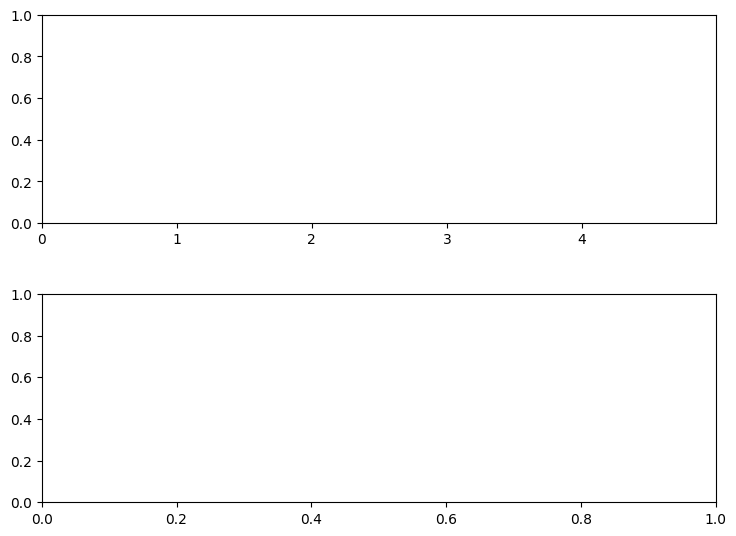

In [60]:
import matplotlib.pyplot as plt
# --- Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plt.tight_layout(pad=3.0)

# Configure axes
ax1.set_xlim(0, T)
ax1.set_ylim(min(x_t) * 1.1, max(x_t) * 1.1)
ax1.set_xlabel("Time")
ax1.set_ylabel("State x(t)")

ax2.set_xlim(0, T)
ax2.set_ylim(min(u_t) * 1.1, max(u_t) * 1.1)
ax2.set_xlabel("Time")
ax2.set_ylabel("Control u*(t)")

# Lines for animation
line1, = ax1.plot(t, x_t, color='tab:blue', lw=2)
line2, = ax2.plot(t, u_t, color='tab:red', lw=2)